In [1]:
from pathlib import Path
import os
import time
import numpy as np
import torch

import warnings
warnings.filterwarnings('ignore')

from data_loader import *
from model import *
from test import *


# pre-process
def pre_proc(tau, block):
    '''log(tau), 97%'''
    tau_sum = tau.sum(axis=(-1,-2,-3))
    limit = np.percentile(tau_sum, 97)
    bln = tau_sum <= limit#np.ones(len(tau), 'bool')
    tau = np.log(tau)
    return (tau[bln],  block[bln])

def toF_proc(tau):
    '''transfer data derived from pre_proc to F=exp(-tau)'''
    tau = np.exp(-np.exp(tau))
    return tau


# Path and data file name
folder  = Path.cwd().parent / 'Illustris1'
DM_name = ['deltaDM_Illustris1_L75_N600_v2.fits', 
            'vx_DM_Illustris1_L75_N600.fits',
            'vy_DM_Illustris1_L75_N600.fits',
            'vz_DM_Illustris1_L75_N600.fits']
ske_name = 'spectra_Illustris1_N600_xaxis.npy'



# hyper parameters
train_insize = np.array([11, 11, 143]) # x, y, z respctively
train_ousize = np.array([1, 1, 75]) # x, y, z respctively
test_batch = 80
localtime_n = ['2020-01-15 03:59:27']
for localtime_i in localtime_n:
    localtime = time.strptime(localtime_i, '%Y-%m-%d %H:%M:%S')

    
    # device used to train the model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(device=device.index))


    # load dark matter data
    print('Loading dark matter...')
    DM_general = load_DM(folder, DM_name)
    DM_general = DM_general.transpose(0,3,2,1)
    DM_general = DM_general[[0,3,2,1]]
    # basic paramters
    DM_param.pix  = len(DM_general[0])
    DM_param.len  = 75 # in Mpc/h
    DM_param.reso = DM_param.len / DM_param.pix # in Mpc/h
    # test
    if DM_general.shape[1]<train_insize.min():
        raise ValueError('DarkMatter cube size',
            DM_general.shape, 'is too small for train size', train_insize, '.')
    DM_general = torch.tensor(DM_general).float()


    # load skewers
    print('Loading skewers...')
    ske, block = load_skewers(folder, ske_name, train_ousize, DM_param)
    # basic parameters
    ske_len = int(ske.shape[-1])


    # divide the sample to training, validation set, and test set.
    print('Setting test set...')
    with open("id_seperate/id_seperate_%s.txt"\
              %time.strftime("%Y-%m-%d_%H:%M:%S", localtime), "r") as f:
        aa = f.readlines()
        id_seperate = np.array(list(aa[0][::3])).astype('int')
        del aa
    f.close()

    test_ske, test_block = load_test(ske, block, id_seperate,
                                     train_ousize, test_batch, pre_proc)
    del id_seperate
    


    # load model
    print('Loading model...')
    model = SkeNet(ResidualBlock,layers=layers).float().to(device)
    model.load_state_dict(torch.load('params/params_%s.pkl'\
            %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))
    #model.load_state_dict(torch.load('params/HyPhy_%s'\
    #        %time.strftime("%Y-%m-%d_%H:%M:%S", localtime)))



    # loss
    criterion = nn.L1Loss()


    # record starr time
    start_time = time.time()


    # start test
    print('Begin testing...')
    test_outp, test_losses = test(test_ske, test_block, DM_general, DM_param,
                            test_batch, train_insize, model, criterion, device, start_time)

    print("Test Summary: ")
    print("\tTest loss: {}".format(test_losses))
    
    # restore test skewers
    print('Restoring test skewers...')
    nz = (ske_len/train_ousize[2]).astype('int')
    test_outp = test_outp.reshape(-1, nz, train_ousize[0],
                                train_ousize[1], train_ousize[2])\
                                .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
    test_ske = test_ske.numpy().reshape(-1, nz, train_ousize[0],
                                train_ousize[1], train_ousize[2])\
                                .transpose(0, 2, 3, 1, 4).reshape(-1, ske_len)
    test_outp = toF_proc(test_outp)
    test_ske  = toF_proc(test_ske)
    test_coord = test_block.reshape(-1, nz, 3)[:, 0, 0:2].T.reshape(2, 1, 1, -1)
    xcoor = np.arange(train_ousize[0]) - np.arange(train_ousize[0]).mean()
    ycoor = np.arange(train_ousize[1]) - np.arange(train_ousize[1]).mean()
    mesh  = np.expand_dims(np.array(np.meshgrid(xcoor, ycoor)), -1)
    test_block = (test_coord + mesh).transpose(3,2,1,0).reshape(-1, 2).astype(int)
    del test_coord, xcoor, ycoor, mesh


    print('Plotting example skewers...')
    # generate comparison images
    folder_outp = Path.cwd()/'test_figs'/('%s_x'\
            %time.strftime("%Y-%m-%d_%H:%M:%S", localtime))
    if not os.path.exists(folder_outp):
        os.makedirs(folder_outp)
    
    
    from scipy import constants as C
    v_end  = 0.02514741843009228 * C.speed_of_light / 1e3
    F_mean = np.array([test_ske.mean(), test_outp.mean()])
    
    nrange = min(len(test_ske), 50)
    test_sp = np.arange(len(test_ske))
    np.random.seed(99)
    np.random.shuffle(test_sp)
    test_sp1 = test_sp[:int(nrange)].astype('int')
    test_sp2 = test_sp[int(nrange):].astype('int')
    
    bins = int(15)
    accuracy = AverageMeter()
    rela_err = AverageMeter()
    accu_arr = np.zeros(len(test_ske))
    erro_arr = np.zeros(len(test_ske))
    oneDPS   = np.zeros(shape=(3, len(test_ske), bins))
    

    # loop
    for i, ii in enumerate(test_sp1):
        print('Plotting {:{}d}/{}, y{:03d}z{:03d}.png...'\
                .format((i+1), int(np.log10(nrange)+1), nrange,
                        test_block[ii,0], test_block[ii,1]))

        test_block_i = test_block[ii]
        test_outp_i = test_outp[ii]
        test_ske_i = test_ske[ii]
        test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()

        stat_i = test_plot(test_block_i, test_outp_i, test_ske_i,
                          test_DM_i, F_mean, v_end, folder_outp, bins)
        accuracy_i, rela_err_i = stat_i[[3,4]]
        accuracy.update(accuracy_i, 1)
        rela_err.update(rela_err_i, 1)
        accu_arr[ii] = accuracy_i
        erro_arr[ii] = rela_err_i
        oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2]
    
    print('Measuring accuracy of the left skewers...')
    for i, ii in enumerate(test_sp2):
        
        test_block_i = test_block[ii]
        test_outp_i = test_outp[ii]
        test_ske_i = test_ske[ii]
        test_DM_i = DM_general[0, test_block_i[0], test_block_i[1], :].numpy()
        
        stat_i = test_accuracy(test_block_i, test_outp_i, test_ske_i,
                              F_mean, v_end, folder_outp, bins)
        accuracy_i, rela_err_i = stat_i[[3,4]]
        accuracy.update(accuracy_i, 1)
        rela_err.update(rela_err_i, 1)
        accu_arr[ii] = accuracy_i
        erro_arr[ii] = rela_err_i
        oneDPS[:,ii] = stat_i[0], stat_i[1], stat_i[2]
    
    
    print('Plotting average 1DPS and histogram...')
    oneDPS = oneDPS.mean(axis=1)
    oneDPS = oneDPS[~np.isnan(oneDPS)].reshape(3,-1)
    bln = oneDPS[0]<0.1
    accuracy_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[bln].mean()
    rela_err_gen = np.abs((oneDPS[1]-oneDPS[2])/oneDPS[2])[bln].std()
    
    outp_hist, F_hist = np.histogram(test_outp, bins=np.arange(0,1.05,0.05))
    test_hist, F_hist = np.histogram(test_ske, bins=np.arange(0,1.05,0.05))
    outp_hist = np.append(outp_hist, outp_hist[-1]) / len(test_ske)
    test_hist = np.append(test_hist, test_hist[-1]) / len(test_ske)
    bln = (F_hist>=0.1) & (F_hist<0.9)
    accuracy_hist = np.abs((outp_hist-test_hist)/test_hist)[bln].mean()
    rela_err_hist = np.abs((outp_hist-test_hist)/test_hist)[bln].std()
    
    
    fig, axes = plt.subplots(2,2,figsize=(12,10))

    p0=axes[0,0].hist(accu_arr, bins=np.arange(0, 1.7, 0.1), color='grey');
    axes[0,0].set_ylim(axes[0,0].get_ylim())
    p1 = axes[0,0].vlines(x=accu_arr.mean(), ymin=0, ymax=9999, linestyle='--')
    axes[0,0].set_xlabel('accuracy $m$', fontsize=14)
    axes[0,0].set_ylabel('pdf of $m$', fontsize=14)
    axes[0,0].tick_params(labelsize=12, direction='in')
    customs = [p1, 
              Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5)]
    axes[0,0].legend(customs, ['average $m=%.4f$'%accu_arr.mean(),
                            '$N=%d$'%len(accu_arr)], fontsize=12, loc=1)

    axes[0,1].hist(erro_arr, bins=np.arange(0, 1.7, 0.1), color='grey');
    axes[0,1].set_ylim(axes[0,1].get_ylim())
    p2 = axes[0,1].vlines(x=erro_arr.mean(), ymin=0, ymax=9999, linestyle='--')
    axes[0,1].set_xlabel('error $s$', fontsize=14)
    axes[0,1].set_ylabel('pdf of $s$', fontsize=14)
    axes[0,1].tick_params(labelsize=12, direction='in')
    customs = [p2, 
              Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='k', markersize=5)]
    axes[0,1].legend(customs, ['average $s=%.4f$'%erro_arr.mean(),
                            '$N=%d$'%len(erro_arr)], fontsize=12, loc=1)

    p3, = axes[1,0].plot(oneDPS[0], oneDPS[1], label='Predicted')
    p4, = axes[1,0].plot(oneDPS[0], oneDPS[2], label='Real', alpha=0.5)
    axes[1,0].set_xlabel(r'$k\ (\mathrm{s/km})$', fontsize=14)
    axes[1,0].set_ylabel(r'$kP_\mathrm{1D}/\pi$', fontsize=14)
    axes[1,0].set_xscale('log')
    axes[1,0].set_yscale('log')
    axes[1,0].set_ylim(axes[1,0].get_ylim())
    axes[1,0].vlines(x=0.1, ymin=1e-8, ymax=1e8)
    axes[1,0].set_title('Average 1DPS', fontsize=14)
    axes[1,0].tick_params(labelsize=12, direction='in', which='both')
    customs = [p3, p4, 
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3),
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3)]
    axes[1,0].legend(customs, [p3.get_label(), p4.get_label(), '$m=%.3f$'%accuracy_gen,
                        '$s=%.3f$'%rela_err_gen], fontsize=12)
    
    p5, = axes[1,1].step(F_hist, outp_hist, where='post', label='Predicted')
    p6, = axes[1,1].step(F_hist, test_hist, where='post', label='Real', alpha=0.5)
    axes[1,1].set_xlabel(r'$F$', fontsize=18)
    axes[1,1].set_ylabel(r'Counts', fontsize=18)
    axes[1,1].set_xlim([0, 1])
    axes[1,1].set_ylim(axes[1,1].get_ylim())
    axes[1,1].vlines(x=0.1, ymin=0, ymax=6000)
    axes[1,1].vlines(x=0.9, ymin=0, ymax=6000)
    axes[1,1].set_title('Average Histogram of $F$', fontsize=14)
    axes[1,1].tick_params(labelsize=12, direction='in')
    customs = [p5, p6, 
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3),
              Line2D([0], [0], marker='o', color='none',
                          markerfacecolor='k', markersize=3)]
    axes[1,1].legend(customs, [p5.get_label(), p6.get_label(), '$m=%.3f$'%accuracy_hist,
                        '$s=%.3f$'%rela_err_hist], fontsize=12)
    
    plt.savefig(folder_outp / ('average.png'), dpi=300, bbox_inches='tight') 
    plt.close()
    
    
    # record this test
    with open('history.txt', 'a') as f:
        f.writelines('\n\n\nTest History Record:')
        f.writelines('\n\tTest of the training at %s'\
                %time.strftime("%Y-%m-%d %H:%M:%S", localtime))
        f.writelines('\n\tTest loss: %s,  '%str(test_losses)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
        f.writelines('\n\tAverage accuracy: %s,  '%str(accuracy.avg)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
        f.writelines('\n\tAverage relative error: %s,  '%str(rela_err.avg)\
            +time.strftime("%Y-%m-%d, %H:%M:%S", time.localtime()))
    f.close()
    
print('Finished test!')

Using device: Quadro P6000
Loading dark matter...
Loading skewers...
Setting test set...
Loading model...
Begin testing...
Step [ 100/3492] Loss: 0.6042, Time: 34.8902
Step [ 200/3492] Loss: 0.5971, Time: 68.9322
Step [ 300/3492] Loss: 0.5436, Time: 103.4773
Step [ 400/3492] Loss: 0.5433, Time: 137.9120
Step [ 500/3492] Loss: 0.5929, Time: 172.3131
Step [ 600/3492] Loss: 0.6888, Time: 206.6749
Step [ 700/3492] Loss: 0.5498, Time: 240.9936
Step [ 800/3492] Loss: 0.5820, Time: 274.9332
Step [ 900/3492] Loss: 0.5507, Time: 310.8252
Step [1000/3492] Loss: 0.5891, Time: 345.1691
Step [1100/3492] Loss: 0.5481, Time: 379.4153
Step [1200/3492] Loss: 0.6593, Time: 413.7820
Step [1300/3492] Loss: 0.6211, Time: 448.2715
Step [1400/3492] Loss: 0.6248, Time: 482.7746
Step [1500/3492] Loss: 0.6007, Time: 517.2983
Step [1600/3492] Loss: 0.5920, Time: 551.8696
Step [1700/3492] Loss: 0.7313, Time: 586.3610
Step [1800/3492] Loss: 0.6484, Time: 620.9151
Step [1900/3492] Loss: 0.7404, Time: 655.7750
Step 

In [2]:
folder  = Path.cwd().parent / 'Illustris1'
FGPA_name = 'spectra_FGPA_Illustris-1_N600_xaxis.npy'

In [3]:
ske_FGPA = np.load(folder/FGPA_name)
ske_FGPA = np.exp(-ske_FGPA)

In [4]:
FGPA_hist, F_hist = np.histogram(ske_FGPA, bins=np.arange(0,1.05,0.05))
FGPA_hist = np.append(FGPA_hist, FGPA_hist[-1]) / len(ske_FGPA)
bln = (F_hist>=0.1) & (F_hist<0.9)
m_FGPA_hist = np.abs((FGPA_hist-test_hist)/test_hist)[bln].mean()
s_FGPA_hist = np.abs((FGPA_hist-test_hist)/test_hist)[bln].std()

In [5]:
FGPA_mean = ske_FGPA.mean()
FGPA_1DPS = np.zeros(shape=(ske_FGPA.shape[0], bins))
for ii, skes in enumerate(ske_FGPA):

    test_outp_i = ske_FGPA[ii] 
    
    ske_len = len(test_outp_i)
    vaxis  = np.arange(0, v_end, v_end/ske_len)
    rvax_t = np.arange(int(ske_len/2))
    logrv  = np.log10(rvax_t)
    logrv[0] = logrv[1]-10
    rvmin, rvmax = 0, logrv[-1]
    bin_sz = (rvmax-rvmin)/bins
    bins_l = np.arange(rvmin, rvmax, bin_sz).reshape(-1,1)
    bins_r = np.arange(rvmin+bin_sz, rvmax+bin_sz, bin_sz).reshape(-1,1)
    bin_bl = (logrv>=bins_l) & (logrv<bins_r)
    bin_bl[-1,-1] = True
    rvaxis = np.zeros(bins)
    # 1DPS
    outp4fft = (test_outp_i-FGPA_mean)/FGPA_mean
    fft_outp = np.absolute(np.fft.fft(outp4fft))[:int(ske_len/2)]
    onePS_outp = np.zeros(bins)
    for jj in range(bins):
        rvaxis[jj] = 10**logrv[bin_bl[jj]].mean()
        onePS_outp[jj]  = (rvax_t*fft_outp**2)[bin_bl[jj]].mean() * 2
    rvaxis = rvaxis * 2 * np.pi / v_end
    onePS_outp = onePS_outp * 2 * np.pi / v_end
    FGPA_1DPS[ii] = onePS_outp
FGPA_1DPS = FGPA_1DPS.mean(axis=0)
bln = oneDPS[0]<0.1
m_FGPA_ps = np.abs((FGPA_1DPS-oneDPS[2])/oneDPS[2])[bln].mean()
s_FGPA_ps = np.abs((FGPA_1DPS-oneDPS[2])/oneDPS[2])[bln].std()

In [6]:
fig, axes = plt.subplots(2,2,figsize=(12,11))

p0=axes[0,0].hist(accu_arr, bins=np.arange(0, 1.7, 0.1), color='grey');
axes[0,0].set_ylim(axes[0,0].get_ylim())
p1 = axes[0,0].vlines(x=accu_arr.mean(), ymin=0, ymax=9999, linestyle='--')
axes[0,0].set_xlabel('accuracy $m$', fontsize=14)
axes[0,0].set_ylabel('pdf of $m$', fontsize=14)
axes[0,0].tick_params(labelsize=12, direction='in')
customs = [p1, 
          Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='k', markersize=5)]
axes[0,0].legend(customs, ['average $m=%.4f$'%accu_arr.mean(),
                        '$N=%d$'%len(accu_arr)], fontsize=12, loc=1)

axes[0,1].hist(erro_arr, bins=np.arange(0, 1.7, 0.1), color='grey');
axes[0,1].set_ylim(axes[0,1].get_ylim())
p2 = axes[0,1].vlines(x=erro_arr.mean(), ymin=0, ymax=9999, linestyle='--')
axes[0,1].set_xlabel('error $s$', fontsize=14)
axes[0,1].set_ylabel('pdf of $s$', fontsize=14)
axes[0,1].tick_params(labelsize=12, direction='in')
customs = [p2, 
          Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='k', markersize=5)]
axes[0,1].legend(customs, ['average $s=%.4f$'%erro_arr.mean(),
                        '$N=%d$'%len(erro_arr)], fontsize=12, loc=1)

p3, = axes[1,0].plot(oneDPS[0], oneDPS[1], label='Predicted')
p5, = axes[1,0].plot(oneDPS[0], oneDPS[2], label='Real', alpha=0.5)
p4, = axes[1,0].plot(oneDPS[0], FGPA_1DPS, label='FGPA', alpha=0.5, linestyle='--')
axes[1,0].set_xlabel(r'$k\ (\mathrm{s/km})$', fontsize=14)
axes[1,0].set_ylabel(r'$kP_\mathrm{1D}/\pi$', fontsize=14)
axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(axes[1,0].get_ylim())
axes[1,0].vlines(x=0.1, ymin=1e-8, ymax=1e8)
axes[1,0].set_title('Average 1DPS', fontsize=14)
axes[1,0].tick_params(labelsize=12, direction='in', which='both')
customs = [p3,
          Line2D([0], [0], marker='o', color='none',
                      markerfacecolor='k', markersize=3),
          Line2D([0], [0], marker='o', color='none',
                      markerfacecolor='k', markersize=3),
          p4, 
          Line2D([0], [0], marker='o', color='none',
                      markerfacecolor='k', markersize=3),
          Line2D([0], [0], marker='o', color='none',
                      markerfacecolor='k', markersize=3),
          p5]
axes[1,0].legend(customs, [p3.get_label(), '$m=%.3f$'%accuracy_gen,
                    '$s=%.3f$'%rela_err_gen, p4.get_label(), 
                    '$m=%.3f$'%m_FGPA_ps, '$s=%.3f$'%s_FGPA_ps,
                    p5.get_label()], fontsize=12)

p6, = axes[1,1].step(F_hist, outp_hist, where='post', label='Predicted')
p8, = axes[1,1].step(F_hist, test_hist, where='post', label='Real', alpha=0.5)
p7, = axes[1,1].step(F_hist, FGPA_hist, where='post', label='FGPA', alpha=0.5, linestyle='--')
axes[1,1].set_xlabel(r'$F$', fontsize=18)
axes[1,1].set_ylabel(r'Counts', fontsize=18)
axes[1,1].set_xlim([0, 1])
axes[1,1].set_ylim([0,500])#axes[1,1].get_ylim())
axes[1,1].vlines(x=0.1, ymin=0, ymax=6000)
axes[1,1].vlines(x=0.9, ymin=0, ymax=6000)
axes[1,1].set_title('Average Histogram of $F$', fontsize=14)
axes[1,1].tick_params(labelsize=12, direction='in')
customs = [p6,
          Line2D([0], [0], marker='o', color='none',
                      markerfacecolor='k', markersize=3),
          Line2D([0], [0], marker='o', color='none',
                      markerfacecolor='k', markersize=3),
          p7, 
          Line2D([0], [0], marker='o', color='none',
                      markerfacecolor='k', markersize=3),
          Line2D([0], [0], marker='o', color='none',
                      markerfacecolor='k', markersize=3),
          p8]
axes[1,1].legend(customs, [p6.get_label(), '$m=%.3f$'%accuracy_hist,
                    '$s=%.3f$'%rela_err_hist, p7.get_label(),
                    '$m=%.3f$'%m_FGPA_hist, '$s=%.3f$'%s_FGPA_hist,
                    p8.get_label()], fontsize=12)

plt.savefig(folder_outp / ('average_new.png'), dpi=300, bbox_inches='tight') 
plt.close()

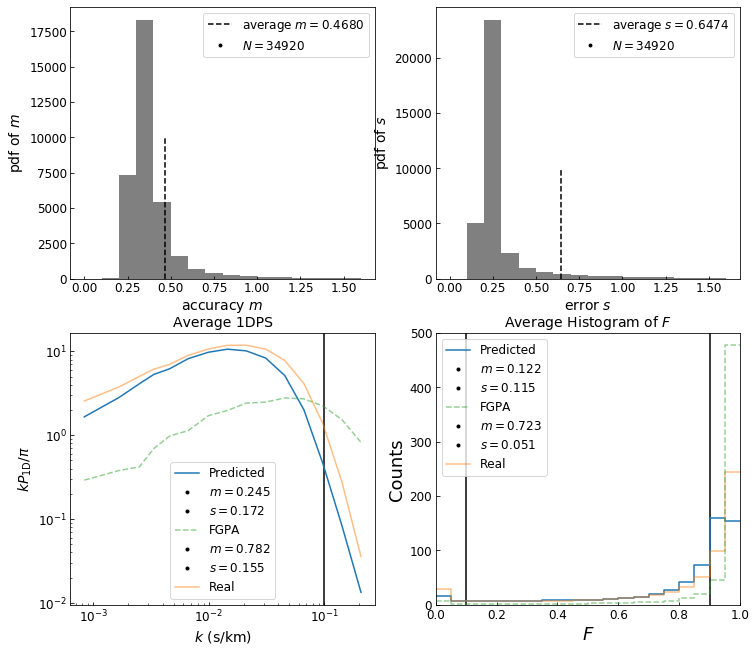

In [7]:
fig

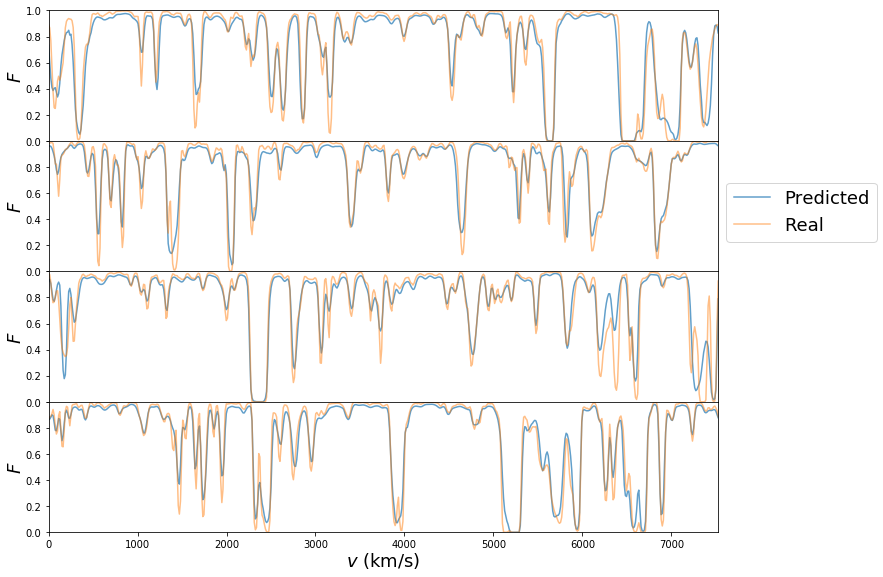

In [8]:
examples = 4
vaxis = vaxis  = np.arange(0, v_end, v_end/ske_len)
order = np.random.randint(len(test_ske), size=examples)

fig, axes = plt.subplots(examples,1,figsize=(12,examples*2.4))

for i in range(examples):
    axes[i].plot(vaxis, test_outp[order[i]], label='Predicted', alpha=0.7)
    axes[i].plot(vaxis, test_ske[order[i]], label='Real', alpha=0.5)
    axes[i].set_xlim([0, max(vaxis)])
    axes[i].set_ylim([0,1])
    axes[i].set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8])
    axes[i].set_ylabel(r'$F$', fontsize=18, labelpad=0.5)
    if i != int(examples-1):
        axes[i].set_xticklabels([])
axes[0].set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes[-1].set_xlabel(r'$v$ (km/s)', fontsize=18, labelpad=0.5)
axes[-1].legend(fontsize=18, bbox_to_anchor=(1.25,2.75))
plt.subplots_adjust(hspace=0)
plt.savefig(folder_outp / ('examples.png'), dpi=600, bbox_inches='tight') 